In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/over-11500-bangla-news-for-nlp/Bangla_news.csv


# Exploratory data analysis (EDA)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Load the dataset

data = pd.read_csv('/kaggle/input/over-11500-bangla-news-for-nlp/Bangla_news.csv')

In [4]:
# General overview of the data
data_info = data.info()
data_description = data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11904 entries, 0 to 11903
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           11904 non-null  object
 1   published_date  11904 non-null  object
 2   reporter        10914 non-null  object
 3   category        11904 non-null  object
 4   url             11904 non-null  object
 5   content         11904 non-null  object
dtypes: object(6)
memory usage: 558.1+ KB


In [5]:
# Checking for missing values
missing_values = data.isnull().sum()
missing_values

title               0
published_date      0
reporter          990
category            0
url                 0
content             0
dtype: int64

In [6]:
# Analyzing the distribution of categories
category_distribution = data['category'].value_counts()
category_distribution

category
sports           2976
international    2976
entertainment    2976
national         2976
Name: count, dtype: int64

In [7]:
# Analyzing the distribution of news articles by reporter
reporter_distribution = data['reporter'].value_counts()

In [8]:
# Convert 'published_date' to datetime format for further time-based analysis
data['published_date'] = pd.to_datetime(data['published_date'], errors='coerce')

/tmp/ipykernel_23/1879087989.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['published_date'] = pd.to_datetime(data['published_date'], errors='coerce')


In [9]:
# Articles per day analysis
articles_per_day = data['published_date'].dt.date.value_counts().sort_index()

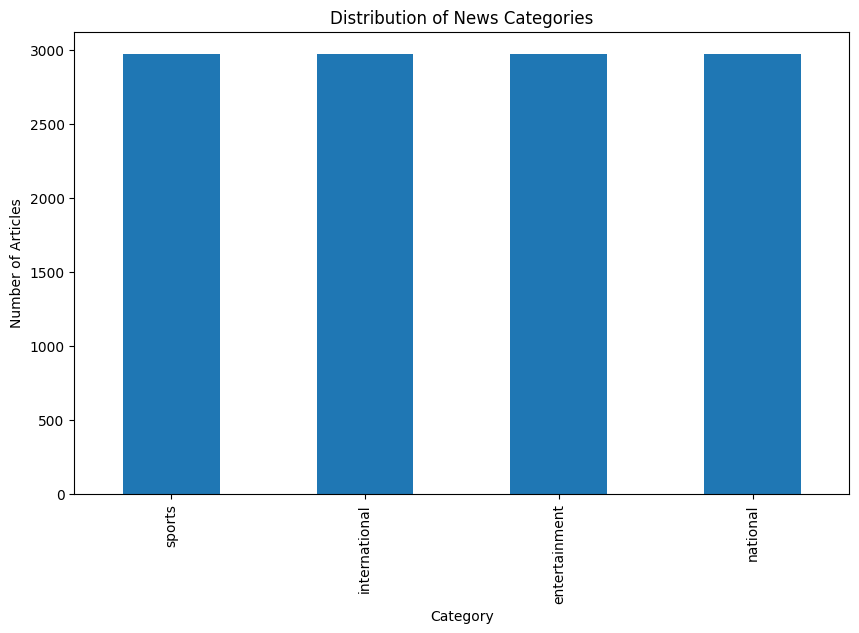

In [10]:
# Plot the distribution of news categories
plt.figure(figsize=(10, 6))
category_distribution.plot(kind='bar')
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.show()

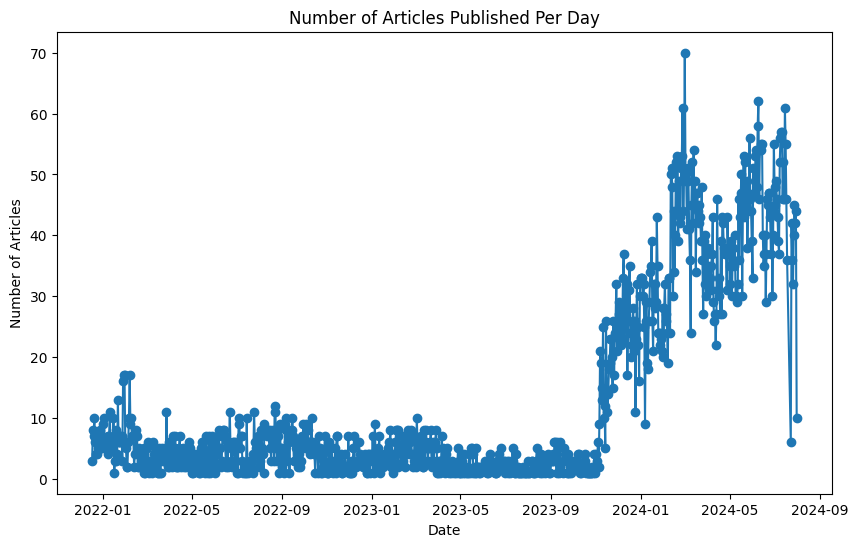

In [11]:
# Plot the number of articles published per day
plt.figure(figsize=(10, 6))
articles_per_day.plot(kind='line', marker='o')
plt.title('Number of Articles Published Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

In [12]:
# Most common categories
category_distribution = data['category'].value_counts()

print("Category Distribution:")
print(category_distribution)

Category Distribution:
category
sports           2976
international    2976
entertainment    2976
national         2976
Name: count, dtype: int64


In [13]:
# Count missing reporters
missing_reporters = data['reporter'].isnull().sum()
print(f"Number of articles without a reporter: {missing_reporters}")

Number of articles without a reporter: 990


In [14]:
# Calculate word count for each article
data['content_length'] = data['content'].apply(lambda x: len(str(x).split()))

# Calculate the average length
average_length = data['content_length'].mean()
print(f"Average article length: {average_length:.2f} words")

Average article length: 76.01 words


In [15]:
# Top reporters
top_reporter = data['reporter'].value_counts().idxmax()
top_reporter_count = data['reporter'].value_counts().max()

print(f"Top Reporter: {top_reporter} with {top_reporter_count} articles")

Top Reporter: এএম with 1393 articles


In [16]:
# Day with most articles
most_articles_day = articles_per_day.idxmax()
most_articles_count = articles_per_day.max()

print(f"Highest number of articles was on {most_articles_day}: {most_articles_count} articles")


Highest number of articles was on 2024-03-01: 70 articles


In [17]:
# Average content length per category
avg_length_per_category = data.groupby('category')['content_length'].mean()

print("Average Article Length by Category:")
print(avg_length_per_category)


Average Article Length by Category:
category
entertainment    84.685484
international    68.993952
national         64.348454
sports           86.016801
Name: content_length, dtype: float64


In [18]:
# Checking for duplicate titles
duplicate_titles = data.duplicated('title').sum()
print(f"Number of duplicate titles: {duplicate_titles}")


Number of duplicate titles: 70


# Model Train

In [19]:
!pip install datasets


In [20]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [21]:
df = pd.read_csv('/kaggle/input/over-11500-bangla-news-for-nlp/Bangla_news.csv')

In [22]:
# Step 4: Data Preprocessing
df_clean = df[['content', 'category']].dropna()

In [23]:
# Step 5: Split into Training and Validation Sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_clean['content'].tolist(), 
    df_clean['category'].tolist(), 
    test_size=0.2, 
    random_state=42
)

In [24]:
# Step 6: Encode Labels
label_to_id = {label: idx for idx, label in enumerate(set(train_labels))}
id_to_label = {idx: label for label, idx in label_to_id.items()}

In [25]:
train_labels_enc = [label_to_id[label] for label in train_labels]
val_labels_enc = [label_to_id[label] for label in val_labels]

In [26]:
print(label_to_id)

{'national': 0, 'sports': 1, 'entertainment': 2, 'international': 3}


In [27]:
import os
os.environ["WANDB_MODE"] = "disabled"  # Disable Weights & Biases logging

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
# Step 7: Tokenize the Data
model_name = "bert-base-multilingual-cased"  # Multilingual BERT model
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [30]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

In [31]:
# Step 8: Create PyTorch Dataset Class
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [32]:
# Create Dataset Objects
train_dataset = NewsDataset(train_encodings, train_labels_enc)
val_dataset = NewsDataset(val_encodings, val_labels_enc)

In [33]:

# Step 9: Load Pretrained Model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(label_to_id)
).to(device)



model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# Step 10: Define Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [35]:
# Step 11: Set Training Arguments
training_args = TrainingArguments(
    output_dir='./results',          
    evaluation_strategy="epoch",     
    learning_rate=2e-5,             
    per_device_train_batch_size=8,   
    per_device_eval_batch_size=8,    
    num_train_epochs=1,              
    weight_decay=0.01,               
    logging_dir='./logs',            
    logging_steps=10,
    save_total_limit=1,              
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [36]:
# Step 12: Initialize Trainer
trainer = Trainer(
    model=model,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
    compute_metrics=compute_metrics      
)

In [37]:
# Step 13: Train the Model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.172900,0.183745,0.949181,0.949155,0.949447,0.949181


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=596, training_loss=0.3052714454047632, metrics={'train_runtime': 614.6896, 'train_samples_per_second': 15.492, 'train_steps_per_second': 0.97, 'total_flos': 2505651573854208.0, 'train_loss': 0.3052714454047632, 'epoch': 1.0})

In [38]:
# Step 14: Evaluate the Model
results = trainer.evaluate()
print(results)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.18374517560005188, 'eval_accuracy': 0.9491810163796724, 'eval_f1': 0.9491545927329772, 'eval_precision': 0.9494471924026435, 'eval_recall': 0.9491810163796724, 'eval_runtime': 44.2645, 'eval_samples_per_second': 53.79, 'eval_steps_per_second': 3.366, 'epoch': 1.0}


In [39]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [40]:
text = "প্যারিস অলিম্পিক যেন হয়ে উঠেছে ভুলের আসর"
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()

id_to_label = {0: "Class 0", 1: "Class 1", 2: "Class 2", 3: "Class 3"}
print(f"Predicted Class: {id_to_label[predicted_class]}")

Predicted Class: Class 1


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


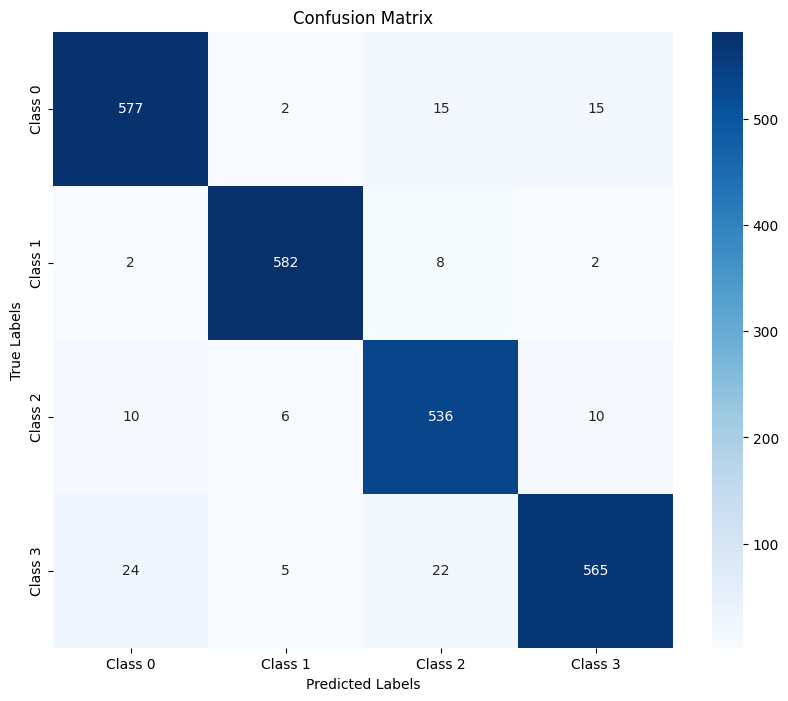

In [41]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

predictions = trainer.predict(val_dataset)

pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

conf_matrix = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[id_to_label[i] for i in range(len(id_to_label))], 
            yticklabels=[id_to_label[i] for i in range(len(id_to_label))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
